In [1]:
import torch
from CzcWav2vec2 import (
    Wav2Vec2ForPreTraining_mfcc,
    Wav2Vec2ForPreTraining_mfcc_auxiliary,
    get_czc_scheduler,
    get_w2v2_scheduler,
    Wav2Vec2ForPreTraining_mae,
    _compute_mask_indices_random
)
from speechbrain.lobes import features
from transformers import Wav2Vec2Processor,Wav2Vec2Config
from datasets import DatasetDict, concatenate_datasets, load_dataset, load_from_disk
from torchaudio import sox_effects
from transformers.models.wav2vec2.modeling_wav2vec2 import Wav2Vec2ForPreTrainingOutput, Wav2Vec2ForPreTraining, \
    _compute_mask_indices, _sample_negative_indices, Wav2Vec2ForSequenceClassification, Wav2Vec2Model,Wav2Vec2BaseModelOutput


In [3]:
!pip install --upgrade git+git://github.com/sovrasov/flops-counter.pytorch.git

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Cloning git://github.com/sovrasov/flops-counter.pytorch.git to /tmp/pip-req-build-r7v6k4al
  Running command git clone -q git://github.com/sovrasov/flops-counter.pytorch.git /tmp/pip-req-build-r7v6k4al
^C
ERROR: Operation cancelled by user


In [6]:
from ptflops import get_model_complexity_info
macs, params = get_model_complexity_info(model_mae, (4, 16000), as_strings=True,
                                       print_per_layer_stat=True, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

RuntimeError: Expected 3-dimensional input for 3-dimensional weight [512, 1, 10], but got 4-dimensional input of size [1, 1, 4, 16000] instead

In [4]:
model_mae = Wav2Vec2ForPreTraining_mae.from_pretrained("/home/work/w2v2_pretrain/training_output/pretrain_hf/mae-fbank80-norm-allmask95-checkpoint-17000")
# model_aux = Wav2Vec2ForPreTraining_mfcc_auxiliary.from_pretrained("/home/work/w2v2_pretrain/training_output/pretrain_hf/w2v2-aishell2-aux-z-l2-39-checkpoint-74000")
# model_aux = Wav2Vec2ForPreTraining_mfcc_auxiliary.from_pretrained("/home/work/w2v2_pretrain/training_output/pretrain_hf/w2v2-aishell2-aux-c-l21-39-checkpoint-57000")
# config = Wav2Vec2Config.from_pretrained(
#     "/data2_from_58175/huggingface/models/wav2vec2-base_",
#     gradient_checkpointing=False,
# )
# model_mae = Wav2Vec2ForPreTraining_mae(config)

In [8]:
# !pip install thop
from thop import profile
flops,params = profile(model_mae,torch.randn(4,16000),verbose=False)

RuntimeError: Expected 3-dimensional input for 3-dimensional weight [512, 1, 10], but got 2-dimensional input of size [16000, 1] instead

In [4]:
model_mae

Wav2Vec2ForPreTraining_mae(
  (wav2vec2): Wav2Vec2Model_mae(
    (feature_extractor): Wav2Vec2FeatureExtractor(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        )
        (2): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        )
        (3): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        )
        (4): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        )
        (5): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        )
    

In [5]:
processor = Wav2Vec2Processor.from_pretrained("/data2_from_58175/huggingface/models/processor_aishell")
aishell = load_from_disk("/home/work/w2v2_pretrain/hf_datasets_aishell2/dev")
file_path_list = aishell[:1]["file"]
input_features = []
for file_path in file_path_list:
    waveform = sox_effects.apply_effects_file(path=file_path, effects=[['rate', str(16000)]])[0]
    waveform = waveform[0]
    feature_normalized = (waveform - torch.mean(waveform)) / torch.sqrt(torch.var(waveform) + 1e-5)
    input_features.append({"input_values": feature_normalized})
batch = processor.pad(
    input_features,
    padding=True,
    return_tensors="pt",
)

file /data2_from_58175/huggingface/models/processor_aishell/config.json not found
/work/anaconda3/envs/fairseq/lib/python3.8/site-packages/transformers-4.12.0-py3.8.egg/transformers/feature_extraction_utils.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = as_tensor(value)


In [ ]:
device = batch["input_values"].device
batch_size = batch["input_values"].shape[0]
mask_indices_seq_length = model_aux._get_feat_extract_output_lengths(
    batch["input_values"].shape[-1])
print(f"mask_indices_seq_length = {mask_indices_seq_length}")
features_shape = (batch_size, mask_indices_seq_length)
if batch["attention_mask"] is not None:
    # compute real output lengths according to convolution formula
    batch["sub_attention_mask"] = model_aux._get_feature_vector_attention_mask(
        mask_indices_seq_length, batch["attention_mask"]
    )
# sample randomly masked indices
mask_time_indices = _compute_mask_indices(
    features_shape,
    0.35,
    model_aux.config.mask_time_length,
    attention_mask=batch['sub_attention_mask'],
)
batch["mask_time_indices"] = torch.tensor(mask_time_indices, dtype=torch.long, device=device)
print(batch["mask_time_indices"].sum(-1))
sampled_negative_indices = _sample_negative_indices(
    features_shape,
    model_aux.config.num_negatives,
    mask_time_indices=batch["sub_attention_mask"],
)
batch["sampled_negative_indices"] = torch.tensor(sampled_negative_indices, dtype=torch.long, device=device)
batch.pop("sub_attention_mask")


In [26]:
device = batch["input_values"].device
batch_size = batch["input_values"].shape[0]
mask_indices_seq_length = model_mae._get_feat_extract_output_lengths(
    batch["input_values"].shape[-1])
print(f"mask_indices_seq_length = {mask_indices_seq_length}")
features_shape = (batch_size, mask_indices_seq_length)
if batch["attention_mask"] is not None:
    # compute real output lengths according to convolution formula
    batch["sub_attention_mask"] = model_mae._get_feature_vector_attention_mask(
        mask_indices_seq_length, batch["attention_mask"]
    )
# sample randomly masked indices
mask_time_indices = _compute_mask_indices(
    features_shape,
    model_mae.config.mask_time_prob,
    model_mae.config.mask_time_length,
    attention_mask=batch['sub_attention_mask'],
)
# mask_time_indices = _compute_mask_indices_random(
#     features_shape,
#     0.75,
#     attention_mask=batch['sub_attention_mask'],
# )
batch["mask_time_indices"] = torch.tensor(mask_time_indices, dtype=torch.long, device=device)
print(batch["mask_time_indices"].sum(-1)/batch["sub_attention_mask"].sum(-1))
batch.pop("sub_attention_mask")

mask_indices_seq_length = 116
tensor([0.7069])


tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True]])

In [27]:
# batch["input_values"] = torch.randn(batch["input_values"].shape)
# batch["input_values"] = torch.randn((1,60000))
output = model_mae(**batch)
print(output)

Wav2Vec2ForPreTrainingOutput_mfcc([('loss', tensor(30.7547, grad_fn=<SumBackward0>)), ('mfcc_pred', tensor([[-1.4866e+00,  1.3264e-03, -2.0785e-01,  ..., -5.8189e-01,
         -9.6845e-01, -1.5255e+00],
        [-3.8845e+00, -3.0342e+00, -2.2748e+00,  ..., -6.9673e-01,
         -9.2253e-01, -1.2981e+00],
        [-3.4270e+00, -2.7253e+00, -2.4929e+00,  ..., -7.1054e-01,
         -9.1696e-01, -1.2454e+00],
        ...,
        [-3.6181e+00, -2.8236e+00, -3.5476e+00,  ..., -1.8508e-01,
         -4.4496e-01, -8.7659e-01],
        [-4.0470e+00, -3.2604e+00, -3.3563e+00,  ..., -4.6196e-01,
         -6.9313e-01, -1.0833e+00],
        [-3.9541e+00, -3.2726e+00, -2.8673e+00,  ..., -3.0258e-01,
         -5.1101e-01, -8.9377e-01]], grad_fn=<ReshapeAliasBackward0>)), ('mfcc_target', tensor([[-1.7917, -0.2275, -0.3907,  ..., -0.9510, -1.6201, -2.9200],
        [-3.6562, -3.3247, -2.2891,  ..., -0.5941, -0.8462, -1.5509],
        [-3.3609, -3.3609, -3.3609,  ..., -0.7625, -0.8512, -0.9771],
       

In [6]:
compute_mfcc = features.MFCC(win_length=25, hop_length=20, n_mels=40, n_mfcc=13, deltas=True,
                                  left_frames=0, right_frames=0)
mfcc_array = compute_mfcc(batch["input_values"])[0]
mfcc_array.shape

torch.Size([117, 39])

spectrogram shape: (1, 116, 768)


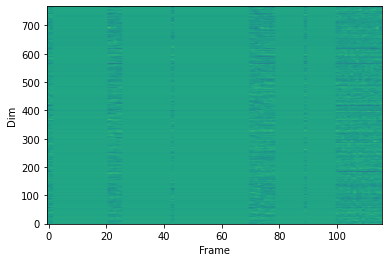

In [28]:
import matplotlib.pyplot as plt
plot_data = output.mae_decoder_input.detach().numpy()
# plt.title('Spectrogram')
plt.xlabel('Frame')
# plt.ylabel('Frequency')
plt.ylabel('Dim')
print('spectrogram shape:', plot_data.shape)

plt.imshow(plot_data.T, aspect='auto', origin='lower',)
plt.show()

spectrogram shape: (116, 80)


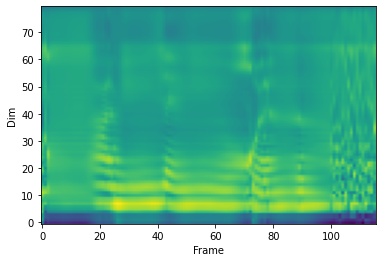

In [29]:
import matplotlib.pyplot as plt
plot_data = output.mfcc_pred.detach().numpy()
# plt.title('Spectrogram ')
plt.xlabel('Frame')
# plt.ylabel('Frequency')
plt.ylabel('Dim')
print('spectrogram shape:', plot_data.shape)
plt.imshow(plot_data.T, aspect='auto', origin='lower',)
plt.show()

spectrogram shape: (116, 80)


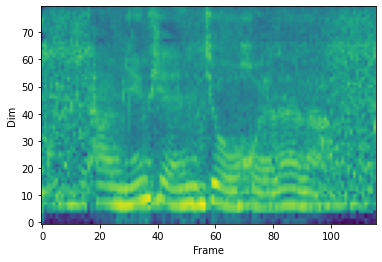

In [30]:
import matplotlib.pyplot as plt
plot_data = output.mfcc_target.detach().numpy()
# plt.title('Spectrogram ')
plt.xlabel('Frame')
# plt.ylabel('Frequency')
plt.ylabel('Dim')
print('spectrogram shape:', plot_data.shape)
plt.imshow(plot_data.T, aspect='auto', origin='lower',)
plt.show()

spectrogram shape: (116, 39)


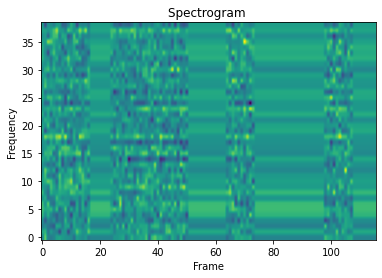

In [42]:
import matplotlib.pyplot as plt
plt.title('Spectrogram ')
plt.xlabel('Frame')
plt.ylabel('Frequency')
print('spectrogram shape:', output.mfcc_pred.detach().numpy().shape)
plt.imshow(output.mfcc_pred.detach().numpy().T, aspect='auto', origin='lower',)
plt.show()

audio shape: torch.Size([51040])


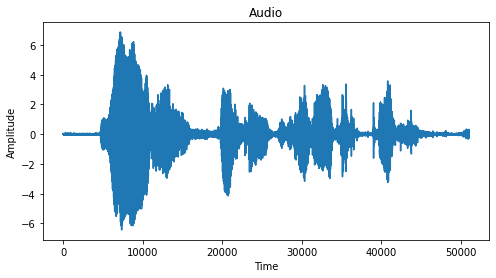

In [19]:
import numpy as np
def plot_time_series(wav):
    assert (
            wav.ndim==1
        ), f"Make sure the input have only one dim."
    fig = plt.figure(figsize=(8, 4))
    plt.title('Audio')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    print('audio shape:', wav.shape)
    plt.plot(np.linspace(0, len(wav), len(wav)), wav)
    plt.show()
plot_time_series(batch['input_values'][0])

In [3]:
t = torch.tensor([[1,1,1,0,1,1]],dtype=torch.float32)
t =t[None,:]
c = torch.nn.Conv1d(1, 400, kernel_size=(400,), stride=(320,), bias=False)
# 构建固定卷积核需要大写Tensor
# c.weight.data = torch.Tensor(torch.ones(1,1,3))
c.weight.data = torch.Tensor(torch.eye(400).unsqueeze(1))
c.weight.requires_grad=False

In [79]:
extract_features = model_mae.wav2vec2.feature_extractor(batch["input_values"]).transpose(1, 2)
attention_mask = model_mae._get_feature_vector_attention_mask(extract_features.shape[1], batch["attention_mask"])

In [103]:
extract_features.shape
# attention_mask.shape

torch.Size([4, 198, 512])

In [91]:
attention_mask

tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True, False, False, False, False,
         False, False, False, False, False, False, F

In [115]:
hidden_states = extract_features

In [114]:
hidden_states.shape

torch.Size([4, 103, 512])

In [101]:
# ~mask_time_indices
attention_mask

tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True, False, False, False, False,
         False, False, False, False, False, False, F

In [126]:
~mask_time_indices[0]

tensor([False, False, False, False, False, False, False, False, False, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False, False, False, False, False, False, False, False, False,
        False,  True,  True,  True, False, False, False, False, False, False,
        False, False, False, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True,  True,  True,  True,  True, False, False,
        False, False, False, False, False, False, False, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, 

In [127]:
mask_time_indices = batch["mask_time_indices"].bool()
from torch.nn.utils.rnn import pad_sequence
hidden_states_list = []
for index in range(hidden_states.shape[0]):
    hidden_states_list.append(hidden_states[index][~mask_time_indices[index] * attention_mask[index]])
    print((~mask_time_indices[index]).sum(-1))
    print(attention_mask[index].sum(-1))
#     print(attention_mask[index])
    print((hidden_states[index][~mask_time_indices[index] * attention_mask[index]]).shape)
hidden_states_ = pad_sequence(hidden_states_list,True, 0)
hidden_states_.shape
# attention_mask = (hidden_states != 0)[:,:,0]

tensor(140)
tensor(116)
torch.Size([58, 512])
tensor(103)
tensor(198)
torch.Size([103, 512])
tensor(129)
tensor(122)
torch.Size([53, 512])
tensor(152)
tensor(108)
torch.Size([62, 512])


torch.Size([4, 103, 512])

In [135]:
(hidden_states_.sum(-1) != 0)

tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True

In [132]:
hidden_states_

tensor([[[0.0424, 0.2917, 0.0917,  ..., 0.3645, 0.1315, 0.3425],
         [0.1981, 0.3315, 0.2335,  ..., 0.3861, 0.1905, 0.3659],
         [0.2860, 0.4757, 0.3357,  ..., 0.2426, 0.4161, 0.4442],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0571, 0.0885, 0.0557,  ..., 0.0588, 0.0283, 0.0980],
         [0.0619, 0.0709, 0.0544,  ..., 0.0727, 0.0338, 0.1433],
         [0.0380, 0.1919, 0.1447,  ..., 0.1176, 0.0788, 0.2036],
         ...,
         [0.0560, 0.0451, 0.0369,  ..., 0.1149, 0.0172, 0.0722],
         [0.0497, 0.0510, 0.0502,  ..., 0.0474, 0.0071, 0.0899],
         [0.0283, 0.1113, 0.0350,  ..., 0.0880, 0.0042, 0.1022]],

        [[0.0223, 0.0929, 0.0501,  ..., 0.0839, 0.0574, 0.1046],
         [0.0758, 0.1935, 0.0653,  ..., 0.1021, 0.0537, 0.1349],
         [0.0817, 0.1039, 0.0780,  ..., 0.1530, 0.0786, 0.